Streaming output truncated to the last 5000 lines.
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000

<Figure size 640x480 with 0 Axes>

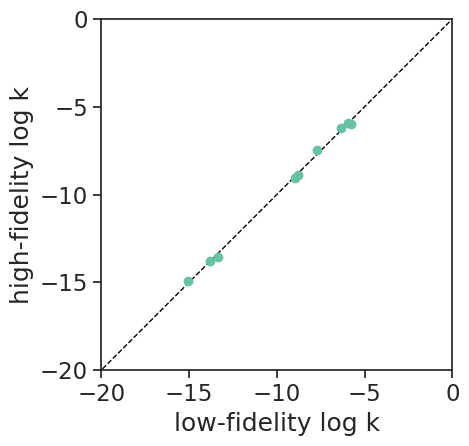

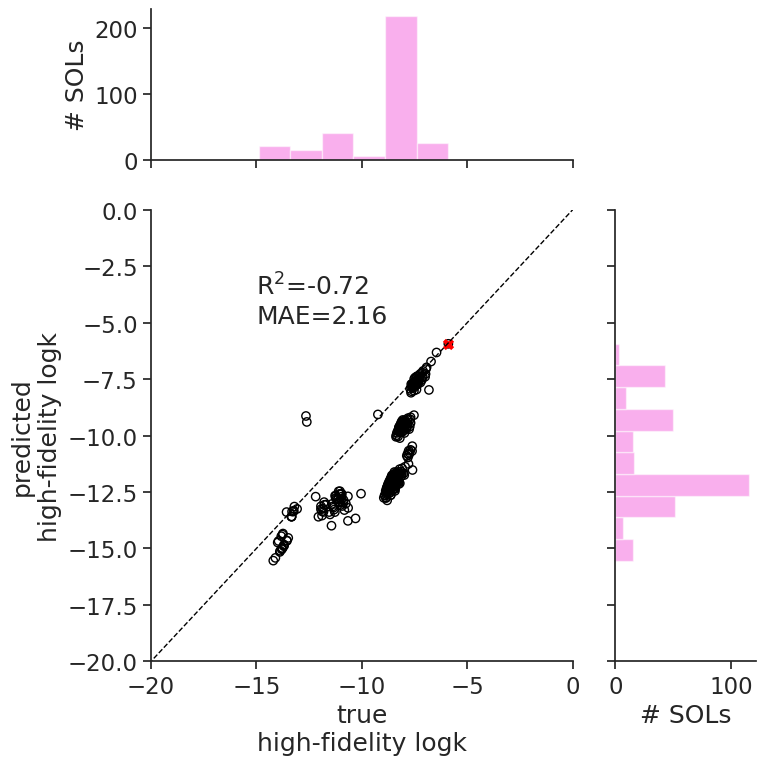

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


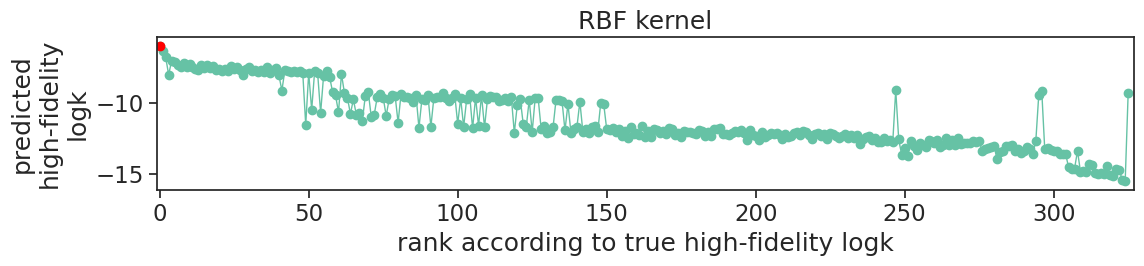

(array([325]),)

In [ ]:
# # -----------------------------
# #  Install necessary packages (based on Python>3.8)
# # -----------------------------
!pip install botorch
!pip install --upgrade botorch
!pip install --upgrade botorch gpytorch

!pip install gpytorch
!pip install scipy
!pip install -U scikit-learn
# -----------------------------
#  Load all libraries required.
# -----------------------------
import torch
import gpytorch
from botorch.models import SingleTaskMultiFidelityGP
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
# from botorch import fit_gpytorch_model OLD!!!!
from botorch import fit_gpytorch_mll
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
import numpy as np
import pandas as pd
import pickle
import h5py # for .jld2 files
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
# -----------------------------
#  figure settings
# -----------------------------
import seaborn as sns
sns.set(style='ticks', palette='Set2', font_scale=1.5, rc={"lines.linewidth": 3})
sns.despine()
# plt.rcParams.update({'font.size': 16})
# plt.rcParams['figure.dpi'] = 1200 # 600-1200 for paper quality
# save_figures = True

discrete_fidelities = [1/3, 2/3] # set of discrete fidelities (in ascending order) to select from this cannot be changed.
ablation_study_flag = False # make features have no information for a baseline. to gauge feature importance
from google.colab import files
uploaded = files.upload()
import pandas as pd
file = file = pd.read_excel('solvents_t1.xlsx')
feature_names = list(file.columns[:-1])

# feature matrix in torch tensor
X = torch.from_numpy(np.array(file.iloc[:,1:8]))
if ablation_study_flag:
    # suffle columns
    for j in range(X.size()[1]):
        shuffled_row_ids - torch.randper(X.size()[0])
        X[:, j] = X[shuffled_row_ids, j]
# simulation data
y = [torch.from_numpy(np.array(file["lnk_MLR"])),
     torch.from_numpy(np.array(file["lnk_QM"][:]))]

print("=====Top solvent is====")
p1 = file[file["lnk_QM"] == file["lnk_QM"].max()]["Solvent"].iloc[0]
p2 = file[file["lnk_QM"] == file["lnk_QM"].max()]["lnk_QM"].iloc[0]
print("The best sovlent found is {} and its lnk_QM value is {}".format(p1,p2))
print("=======================")

# associated simulation costs
cost = [np.transpose(np.array(file["MLR_total_eleapsed_time"][:])),       # [min]
        np.transpose(np.array(file["QM_total_eleapsed_time"][:]))]        # [min]

# total number of solvents (SOLs) in data set
nb_SOLs = X.shape[0]
# The first 9 solvents are our baseline that will be used for the initialisation of BO
file.head(9)

nb_solvent = 9           # The number of solvents in the initial set
nb_runs = 50             # Total budget, i.e., the number of iteration
num_features = len(X[0]) # Number of feature

init_sol_ids = np.array(range(0,nb_solvent))

# Print the solvent features (X)
for i, f in enumerate(feature_names):
    if (i>0) & (i<num_features+1):
        print("{}: {}".format(i, f))

for j in range(X.size()[1]):
    X[:, j] = (X[:, j] - torch.min(X[:, j]).item()) / (torch.max(X[:, j]).item() - torch.min(X[:, j]).item())

# normalization worked
assert np.allclose(torch.min(X, 0).values, torch.zeros(num_features))
assert np.allclose(torch.max(X, 0).values, torch.ones(num_features))

# cost
print("total high-fidelity cost   :", sum(cost[1]).item(), "[min]")
print("total low-fidelity cost    :", sum(cost[0]).item(), "[min]")
print("average high-fidelity cost :", np.mean(cost[1]), "[min]")
print("average low-fidelity cost  :", np.mean(cost[0]), "[min]")
print("average cost ratio         :", np.mean(cost[1] / cost[0]))

# data shape
print("\nraw data - \n\tX:", X.shape)
for f in range(2):
    print("\tfidelity:", f)
    print("\t\ty:", y[f].shape)
    print("\t\tcost: ", cost[f].shape)

# normalization check
print("\nEnsure features are normalized - ")
print("max:\n", torch.max(X, 0).values)
print("min:\n", torch.min(X, 0).values)
print("width:\n",torch.max(X, 0).values - torch.min(X, 0).values)
print("mean:\n", torch.mean(X, 0))
print("std:\n", torch.std(X, 0))

# return list of fidelity id's (0's and 1's) from the acquired set.
def get_f_ids(acquired_set):
    if acquired_set.dim() == 0:
        return acquired_set.round().to(dtype=int)
    else:
        f_ids = [a[0].round().to(dtype=int) for a in acquired_set]
        return torch.tensor(f_ids)

# get the list of high-fidelity y_max's from iter-to-iter
# returns an array.
# element i is best y-max high fidelity seen up to iteration i.
def get_y_maxes_hf_acquired(acquired_set):
    nb_iters = len(acquired_set)
    y_maxes = np.zeros(nb_iters)
    # we want the maximum y value (only high-fidelity) up to a given iteration
    y_max = 0.0 # update this each iteration.
    for i, (f_val, cof_id) in enumerate(acquired_set):
        f_id = get_f_ids(torch.tensor(f_val))
        assert f_id in [0, 1]
        y_acq_this_iter = y[f_id][int(cof_id)]
        # i is iteration index
        if f_id == 1 and y_acq_this_iter > y_max:
            y_max = y_acq_this_iter # over-write max
        y_maxes[i] = y_max
    return y_maxes


# find accumulated cost, given acquired set.
# returns an array.
# element i is cost accumulated till iteration i
def accumulated_cost(acquired_set):
    nb_iters = len(acquired_set)
    accumulated_cost = np.zeros(nb_iters)
    for i, (f_val, cof_id) in enumerate(acquired_set):
        cof_id = int(cof_id.item())
        f_id = f_val.round().to(dtype=int).item()
        if i == 0:
            accumulated_cost[i] = cost[f_id][cof_id]
        else:
            accumulated_cost[i] = accumulated_cost[i-1] + cost[f_id][cof_id]
    return accumulated_cost

# calcualte the fraction of sims up to that point that are a given fidelity
# entry i is fraction of sims up to that point that are fidelity fidelity.
def calc_fidelity_fraction(acquired_set, fidelity):
    assert fidelity in [1/3, 2/3]
    nb_iters = len(acquired_set)
    fid_frac = np.zeros(nb_iters)
    for i in range(nb_iters):
        fid_frac[i] = sum(acquired_set[:, 0][:i+1] == fidelity) / (i+1)
    return fid_frac

def initialize_acquired_set(initializing_SOLs, discrete_fidelities):
    return torch.tensor([[f_id, sol_id] for sol_id in initializing_SOLs for f_id in discrete_fidelities])

# construct feature matrix of acquired points.
# the last entry is the fidelity parameter.
def build_X_train(acquired_set):
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    f_ids = torch.tensor([a[0] for a in acquired_set])
    assert f_ids[0] in [1/3, 2/3]
    return torch.cat((X[cof_ids, :], f_ids.unsqueeze(dim=-1)), dim=1)

# construct output vector for acquired points
def build_y_train(acquired_set):
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set] # this is where the "experiment" is conducted
    return torch.tensor([y[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids)]).unsqueeze(-1)

# construct vector to track cost of acquired points
# entry i is cost of acquired Solvent i
def build_cost(acquired_set):
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return torch.tensor([cost[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids)]).unsqueeze(-1)

# construct vector to track cost of acquired points
# entry i is cost of acquired COF i within a given fidelity_id
def build_cost_fidelity(acquired_set, fidelity_id):
    assert fidelity_id in [0, 1]
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return torch.tensor([cost[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids) if f_id == fidelity_id]).unsqueeze(-1)
!pip install GPytorch
#checking is installed again
from gpytorch.kernels import RBFKernel, ScaleKernel

#init method: construct with super

class FidelityRBFKernel(RBFKernel):
    def __init__(self, lengthscale=1.0, **kwargs):
        super().__init__(**kwargs)
        self.lengthscale = lengthscale
    def forward(self, x1, x2, **params):
        # Extract fidelity dimensions
        z1, z2 = x1[:, -1:], x2[:, -1:]
        return super().forward(z1, z2)

#combine kernels
from gpytorch.kernels import AdditiveKernel
feature_kernel = ScaleKernel(RBFKernel())
fidelity_kernel = FidelityRBFKernel()
#add kernels to make a new kernel
combined_kernel = AdditiveKernel(feature_kernel, fidelity_kernel)
#checking pacakages work
from gpytorch.kernels import RBFKernel, ScaleKernel, AdditiveKernel
from gpytorch.models import ExactGP
# return trained surrogate model
# Train the surrogate model with a custom RBF kernel for fidelities
from gpytorch.kernels import RBFKernel, ScaleKernel, AdditiveKernel
from botorch.models.transforms import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll
from botorch.models import SingleTaskGP

def train_surrogate_model(X_train, y_train):
    outcome_transform = Standardize(m=1)

    #RBF FOR ALL
    covar_module = ScaleKernel(
        RBFKernel(ard_num_dims=X_train.shape[-1])
    )

    #Initialise model
    model = SingleTaskGP(
        train_X=X_train,
        train_Y=y_train,
        covar_module=covar_module,
        outcome_transform=outcome_transform
    )

    # Fit the model
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    return model

# Return the mean and standard deviation of the posterior
# Return the mean and standard deviation of the posterior
def mu_sigma(model, X, fidelity):
    assert fidelity in [1/3, 2/3]
    # Add fidelity dimension to input
    nb_SOLs_here = X.size()[0]
    f = torch.tensor((), dtype=torch.float64).new_ones((nb_SOLs_here, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1)  # Concatenate fidelity as the last column
    # Get the posterior mean and variance
    f_posterior = model.posterior(X_f)
    return f_posterior.mean.squeeze().detach().numpy(), np.sqrt(f_posterior.variance.squeeze().detach().numpy())


# ratio of mean cost of sims of high fidelity to those of fidelity-fidelity, within acquired set so far.
def estimate_cost_ratio(acquired_set, fidelity):
    assert fidelity in [1/3, 2/3]
    f_id = get_f_ids(torch.tensor(fidelity))
    avg_cost_f  = torch.mean(build_cost_fidelity(acquired_set, f_id).float())
    avg_cost_hf = torch.mean(build_cost_fidelity(acquired_set, 1).float())
    cr = avg_cost_hf / avg_cost_f
    return cr.item()
# get the current best y-value of desired_fidelity in the acquired set
def get_y_max(acquired_set, fidelity):
    assert fidelity in [0, 1]
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return np.max([y[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids) if f_id == fidelity])
###
#  efficient multi-fidelity correlation function
#  corr(y at given fidelity, y at high-fidelity)
#  (see notes)
#  This is the second term in the AugEI acquisition function
###
def mfbo_correlation_function(model, X, fidelity):
    assert fidelity in [1/3, 2/3]
    # given fidelity
    f   = torch.tensor((), dtype=torch.float64).new_ones((nb_SOLs, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1) # last col is associated fidelity

    #  high-fidelity
    hf   = torch.tensor((), dtype=torch.float64).new_ones((nb_SOLs, 1)) * discrete_fidelities[-1]
    X_hf = torch.cat((X, hf), dim=1) # last col is associated fidelity

    # combine into a single tensor
    X_all_fid = torch.cat((X_f, X_hf), dim=0)

    # get variance for each fidelity
    var_f = torch.flatten(model.posterior(X_f).variance)
    var_hf = torch.flatten(model.posterior(X_hf).variance) # variance
    # posterior covariance
    cov = torch.diag(model(X_all_fid).covariance_matrix[:X_f.size()[0], X_f.size()[0]:])
    corr = cov / (torch.sqrt(var_f) * torch.sqrt(var_hf))
    return corr
def EI_hf(model, X, acquired_set):
    '''
    This function returns a vector of length X
    The acquired set is the observed set
    The function assigns an EI value to each solvent in X
    '''
    hf_mu, hf_sigma = mu_sigma(model, X, discrete_fidelities[-1]) # hf_mu and hf_sigma are vectors of length 335 (each solvent that was not in the initial set)
    y_max = get_y_max(acquired_set, 1)

    z = (hf_mu - y_max) / hf_sigma
    explore_term = hf_sigma * norm.pdf(z)
    exploit_term = (hf_mu - y_max) * norm.cdf(z)
    ei = explore_term + exploit_term
    return np.maximum(ei, np.zeros(X.size()[0]))
###
#  acquisition function combining the three terms (EI, Corr, CostRatio) as in the Gantzler paper
###
def acquisition_scores(model, X, fidelity, acquired_set):
    assert fidelity in [1/3, 2/3]
    # expected improvement for high-fidelity
    ei = EI_hf(model, X, acquired_set)
    # augmenting functions
    corr_f1_f0 = mfbo_correlation_function(model, X, fidelity)
    cr = estimate_cost_ratio(acquired_set, fidelity)
    scores = torch.from_numpy(ei) * corr_f1_f0 * cr
    return scores.detach().numpy()

# return True if (f_id, cof_id) in acquired set and False otherwise
def in_acquired_set(f_id, cof_id, acquired_set):
    assert f_id in [0, 1]
    fidelity = discrete_fidelities[f_id]
    for this_fidelity, this_cof_id in acquired_set:
        if this_cof_id == cof_id and this_fidelity == fidelity:
            return True
    return False


def run_Bayesian_optimization(nb_iterations, initializing_SOLs, verbose=False, stop_after_top_acquired=True):
    assert nb_iterations > len(initializing_SOLs)

    ###
    #  initialize acquired set
    ###
    acquired_set = initialize_acquired_set(initializing_SOLs, discrete_fidelities)

    # the initial acquired set is a 18x2 vector with fidelities (0.3 and 0.6) and solvent ID (0 to 8, one for each fidelity level)

    for i in range(len(initializing_SOLs), nb_iterations):
        #print("BO iteration: ", i)
        ###
        #  construct training data (perform experiments)
        ###
        X_train = build_X_train(acquired_set)

        # the initial training set is an 18x8 matrix with columns 1-7: features 1: n_square 2: A 3: B 4: Gamma 5: Epsilon 6: Aromaticity 7: Halogenicity and column 8 as fidelity (0.3, 0.6) (again, each row doubles and has either 0.3 or 0.6 in the end)

        y_train = build_y_train(acquired_set)

        # y_train is the non-normalized versions with solvatochromic logk and qm logk in alternating rows (meaning 2 rows for each solvent), again the initial set is an 18x1 matrix

        if verbose:
            print("Initialization - \n")
            print("\tSOL IDs acquired    = ", [acq_[1].item() for acq_ in acquired_set])
            print("\tfidelities acquired = ", [acq_[0].item() for acq_ in acquired_set])
            print("\tcosts acquired      = ", build_cost(acquired_set), " [min]")

            print("\n\tTraining data:\n")
            print("\t\t X train shape = ", X_train.shape)
            print("\t\t y train shape = ", y_train.shape)
            print("\t\t training feature vector = \n", X_train)

        ###
        #  train Model (maximize mll)
        ###



        model = train_surrogate_model(X_train, y_train)

        ###
        #  acquire new (SOL, fidelity) not yet acquired.
        ###
        # entry (fid_id, sol_id) is the acquisition value for fidelity f_id and cof sol_id
        the_acquisition_scores = np.array([acquisition_scores(model, X, fidelity, acquired_set) for fidelity in discrete_fidelities])
        # in the first iteration, this function returns a vector of size 2x355 (first row low fidelity scores, second row high fidelity scores)
        # the acquisiiton scores include the high-fidelity EI x term2 x term3, whereas only term2 and term3 are dependend on the fidelity

        print(the_acquisition_scores)


        # overwrite acquired SOLs/fidelities with negative infinity to not choose these.
        for fidelity, sol_id in acquired_set:
            the_acquisition_scores[get_f_ids(fidelity), sol_id.to(dtype=int)] = - np.inf

        # in the first run, the first nine solvents are overwritten (as these were the training samples)
        # it looks like there is no difference between X and the acquired dataset, as the acquired dataset seems to be part of X

        # select SOL/fidelity with highest aquisition score.
        f_id, sol_id = np.unravel_index(np.argmax(the_acquisition_scores), np.shape(the_acquisition_scores))

        assert f_id in [0, 1]
        assert not in_acquired_set(f_id, sol_id, acquired_set)
        assert np.max(the_acquisition_scores) == the_acquisition_scores[f_id, sol_id]

        # update acquired_set
        acq = torch.tensor([[discrete_fidelities[f_id], sol_id]]) # dtype=int
        acquired_set = torch.cat((acquired_set, acq))
        # acquired set is updated and has now +1 rows. It has two columns, first one is solvent ID and second one is fidelity.
        # implicit here is that all solvents in the acquired set have had the highest acquisition score within the untested ones at one point.

        ###
        #  print useful info
        ###
        if verbose:
            print("\tacquired Solvent ", sol_id, " at fidelity, ", f_id)
            print("\t\ty = ", y[f_id][sol_id].item())
            print("\t\tcost = ", cost[f_id][sol_id])

        if stop_after_top_acquired:
            sol_id_with_max_selectivity = np.argmax(y[1])
            if sol_id_with_max_selectivity == sol_id and f_id == 1:
                print("found top Solvent! exiting.")

    return acquired_set



# ---------------------------------------------
#  construct initial inputs
# ---------------------------------------------
nb_SOLs_initialization = nb_solvent    # at each fidelity, number of SOLs to initialize with
nb_iterations = nb_runs                # BO budget, includes initializing SOLs. This is actually max # iterations

if ablation_study_flag:
    print("ablation study: {}".format(ablation_study_flag))
     # the maximum possible number iterations = num_fidelities * nb_COFs
     # this would efectively constitute a low-fidelity exhaustive search
     # followed by a high-fidelity exhaustive search

    nb_iterations = 2 * nb_SOLs
    print("max. number of iterations: {}".format(nb_iterations))



if not ablation_study_flag:

    # 50 iterations
    # init solvent IDs: [0 1 2 3 4 5 6 7 8]

    acquired_set = run_Bayesian_optimization(nb_iterations, init_sol_ids, verbose=False)


    ## post analysis
    #
    # unpack search results
    f_ids   = [acquired_set[i][0].item()      for i in range(len(acquired_set))]
    sol_ids = [int(acquired_set[i][1].item()) for i in range(len(acquired_set))]

    # which SOL has the largest high-fidelity reaction constant?
    sol_id_with_max_hi_fid_logk = np.argmax(y[1]).item()

    # iteration we found top SOL
    n_iter_top_sol_found = np.where([sol_ids[i] == sol_id_with_max_hi_fid_logk and f_ids[i] > 0.5 for i in range(len(sol_ids))])[0].item()
    print("iteration we acquire top SOLVENT = ", n_iter_top_sol_found)
    print("accumulated cost up to observation of top SOLVENT = ", accumulated_cost(acquired_set)[n_iter_top_sol_found], " [min]")



  # find SOLs that are simualted in with high- and low-fidelity.
hi_fid_sols = [sol_ids[i] for i in range(n_iter_top_sol_found) if f_ids[i] > 0.5]
lo_fid_sols = [sol_ids[i] for i in range(n_iter_top_sol_found) if f_ids[i] < 0.5]

# find SOLs simulated at both fidelities
ids_sols_hi_and_lo_fid = np.intersect1d(hi_fid_sols, lo_fid_sols)
ids_sols_hi_and_lo_fid


# build logk array for plotting,
y_los = [y[0][c].item() for c in ids_sols_hi_and_lo_fid]
y_his = [y[1][c].item() for c in ids_sols_hi_and_lo_fid]

fig = plt.figure()
plt.plot([-100, 100], [-100, 100], linestyle="--", color="k", linewidth=1)
plt.scatter(y_los, y_his, zorder=10)
ax = plt.gca()
plt.xlim(-20, 0)
plt.ylim(-20, 0)
ax.set_aspect("equal", "box")
plt.xlabel("low-fidelity log k")
plt.ylabel("high-fidelity log k")
plt.tight_layout()
plt.show()


# get SOL ids not in acquired set with high-fidelity sims. these are test SOLs for high-fidelity standpoint.
test_sol_ids = [sol_id for sol_id in range(nb_SOLs) if not (sol_id in hi_fid_sols)]
len(test_sol_ids)


sol_id_with_max_hi_fid_logk in test_sol_ids # the SOL with the highest logk should be in here. cuz we didn't acquire it yet.


id_in_test_sols_of_opt_sol = np.where([c == sol_id_with_max_hi_fid_logk for c in test_sol_ids])[0].item()
id_in_test_sols_of_opt_sol


# train surrogate model for test data, on acquired set up till top COF was found.
X_train = build_X_train(acquired_set[:n_iter_top_sol_found])
y_train = build_y_train(acquired_set[:n_iter_top_sol_found])

X_test = X[test_sol_ids, :]

model = train_surrogate_model(X_train, y_train)

# get model predictions on test COFs, for high-fidelity.
y_pred, sigma = mu_sigma(model, X_test, discrete_fidelities[-1])

# plot true vs predicted
y_true = [y[1][c].item() for c in test_sol_ids]

r2 = r2_score(y_true, y_pred)
abserr = mean_absolute_error(y_true, y_pred)

r2_score(y_pred,y_true)


###
#  parity plot
###
gridspec_kw={'width_ratios': [6, 2], 'height_ratios': [2, 6]} # set ratios
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw=gridspec_kw, figsize=(8, 8))
# fig = plt.figure()
ax[0, 1].axis("off")
ax[1, 0].plot([-100, 100], [-100, 100], linestyle="--", color="k", linewidth=1)
# ax = plt.gca()
ax[1, 0].set_xlim(-20, 0)
ax[1, 0].set_ylim(-20, 0)

#ax[1, 0].set_aspect("equal", "box")

ax[1, 0].text(-15, -5, "R$^2$=%.2f\nMAE=%.2f" % (r2, abserr))
ax[1, 0].scatter(y_true, y_pred, fc='none', ec="k")
ax[1, 0].set_xlabel("true\nhigh-fidelity logk")
ax[1, 0].set_ylabel("predicted\nhigh-fidelity logk")
# plot acquired COF
ax[1, 0].scatter(y_true[id_in_test_sols_of_opt_sol], y_pred[id_in_test_sols_of_opt_sol], marker="x", color="red")


###
#  histogram of logk
###
hist_color = sns.color_palette("husl", 8)[7]
ax[0, 0].hist(y_true, color=hist_color, alpha=0.5) #
ax[0, 0].sharex(ax[1, 0])
ax[0, 0].set_ylabel('# SOLs')
plt.setp(ax[0, 0].get_xticklabels(), visible=False) # remove yticklabels

hist_color = sns.color_palette("husl", 8)[7]
ax[1, 1].hist(y_pred, color=hist_color, alpha=0.5, orientation="horizontal") #
ax[1, 1].sharey(ax[1, 0])
ax[1, 1].set_xlabel('# SOLs')
plt.setp(ax[1, 1].get_yticklabels(), visible=False) # remove yticklabels

sns.despine()
plt.tight_layout()
plt.show()



rf = RandomForestRegressor()
rf.fit(X_train[:, :7], y_train)
rf.score(X_test, y_true)

ids_sorted = np.argsort(y_true)[::-1]

plt.figure(figsize=(12, 3))
plt.errorbar(range(len(y_true)), y_pred[ids_sorted], yerr=sigma, linewidth=1, marker="o")
plt.errorbar(0, y_pred[id_in_test_sols_of_opt_sol], yerr=sigma[id_in_test_sols_of_opt_sol], linewidth=1, marker="o", color="red")
plt.xlabel("rank according to true high-fidelity logk")
plt.ylabel("predicted\nhigh-fidelity\nlogk")
plt.xlim(-1, len(test_sol_ids) +1)
plt.title('RBF kernel')
plt.tight_layout()

plt.show()

np.where([sol_id == sol_id_with_max_hi_fid_logk for sol_id in test_sol_ids])


In [ ]:
import matplotlib.pyplot as plt

# Set the global font to serif
plt.rc('font', family='serif')


# Trajectory plots

[[1.47463156e+000 8.69174942e-001 4.53036701e+000 4.00577506e+000
  1.99162901e+000 2.51971935e-007 2.93121031e+000 9.43709982e-001
  2.32135278e+000 2.90422216e+000 2.71964899e+000 2.80729548e+000
  2.53574118e+000 2.45801133e+000 2.42604188e+000 1.28367007e+000
  2.86854521e+000 1.98828585e+000 1.91520059e+000 9.45110703e-001
  8.76853961e-001 2.28830178e+000 1.85386195e+000 1.21994487e+000
  2.25026621e+000 6.66718547e-002 2.31052877e+000 2.87042305e-001
  6.11069966e-001 1.26317164e-002 1.21974685e+000 4.23783426e-001
  1.46808064e+000 1.29757631e+000 4.72797692e-001 1.40182047e+000
  1.43587742e+000 1.06724308e-001 3.55976967e-001 7.05638787e-002
  1.17230354e+000 1.70119102e+000 7.17394557e-001 2.81719071e-003
  1.43208096e+000 9.34259318e-001 4.44639778e-001 5.77479485e-001
  1.00422123e-001 6.17324636e-001 4.12933609e-001 6.11823630e-001
  7.94058762e-001 5.49492268e-002 4.38285968e-001 5.01845685e-001
  3.93142827e-002 7.31687081e+000 2.95806241e-001 4.18517865e-002
  1.656518

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[[ 1.22712749e-015  9.26698754e-008  3.14998469e-004  7.98196130e-132
   5.92391094e-003  1.90283452e-054  2.01488038e-001  5.03252513e-003
   6.43219491e-003  2.26581913e-002  1.33059599e-003  1.09803353e-003
   9.15266677e-011  1.33916954e-004  3.62541655e-005  3.60443167e-009
   2.78151923e-010  1.24896589e-015  1.69321450e-005  3.63091245e-023
   4.45589782e-011  1.22373109e-009  2.59343017e-006  1.58089903e-020
   8.06719550e-039  1.54423692e-080  1.85430799e-014  1.76064537e-028
   6.61179505e-013  8.50298211e-083  6.81881098e-031  3.94347949e-024
   4.48403044e-012  2.20495315e-007  8.40410462e-017  8.14766183e-052
   5.62619900e-018  1.46120942e-095  4.31403777e-036  2.23701712e-048
   6.23540142e-009  6.34231226e-063  8.33266761e-014  5.86451372e-073
   1.51678950e-025  2.47669418e-008  1.74702550e-060  1.21766591e-020
   1.20902160e-039  2.57437910e-018  6.04458426e-015  5.49490136e-065
   5.81003002e-010  1.11712876e-063  1.33690433e-082  5.51790018e-029
   2.06393490e-059  

/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


Streaming output truncated to the last 5000 lines.
  1.49029959e-022 7.11126370e-008 7.19496319e-017 6.17721300e-009
  8.93748133e-009 4.52233875e-018 1.85366149e-004 4.53094681e-003
  1.08962362e-008 8.86743777e-001 1.00392651e-006 5.53715007e-001
  8.91648067e-008 1.18344780e-006 7.31610321e-006 1.50183802e-009
  1.07474426e-001 4.87167390e-014 1.63233718e-014 8.90464034e-005
  2.83599578e-007 2.59734922e-001 5.24036956e-006 5.27972008e-003
  1.54052097e-001 2.52416475e-029 6.44799895e-001 1.07181185e-006
  2.87251836e-012 1.25771958e-008 3.43836709e-001 2.14944340e-001
  2.16136681e-005 2.27097576e-034 1.84251339e-008 1.34318625e-004
  2.28588385e-010 7.88202055e-035 3.76968154e-009 4.96663862e-004
  6.52418904e-004 6.56809980e-009 1.88352647e-029 2.51319129e-019
  9.27993531e-009 4.70707824e-022 8.55954834e-007 6.00786020e-004
  5.63330022e-008 9.81653195e-011 1.82599080e-012 1.46627648e-004
  1.51341541e-012 8.28160850e-004 1.98788604e-015 8.76930494e-009
  4.81353547e-007 5.08494

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


Streaming output truncated to the last 5000 lines.
  2.04585583e-026 2.44409566e-024 2.71401071e-019 2.32054002e-019
  2.07615698e-025 3.94320405e-025 1.74518171e-014 6.67293314e-013
  1.48417235e-027 1.05461820e-013 2.45829918e-019 1.58939017e-017
  4.11563953e-018 2.30433687e-023 1.30514789e-026 2.59463881e-012
  3.13321063e-015 3.94413199e-023 2.50844191e-023 2.91549031e-026
  2.15084715e-023 2.57829626e-016 1.77028675e-018 4.34528343e-013
  1.13296107e-014 3.64699687e-023 8.72633938e-015 8.99772833e-022
  1.26378743e-023 2.41916664e-027 4.32591164e-014 7.80552416e-013
  1.51103600e-017 5.05650026e-028 2.39264000e-026 1.34950781e-015
  2.15103307e-022 2.54236190e-028 3.53096602e-023 3.53515942e-015
  5.73460824e-052 2.69192477e-027 1.41233074e-026 8.47697375e-021
  4.49784883e-028 1.37591992e-025 1.44544287e-025 1.24686632e-056
  3.21611652e-021 4.56244381e-025 8.12072346e-020 6.01581627e-016
  4.60380412e-023 6.59386914e-015 4.84171067e-014 2.79951779e-021
  6.48606112e-032 1.24124

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


Streaming output truncated to the last 5000 lines.
   3.65050110e-167  0.00000000e+000  1.70804155e-264  0.00000000e+000
   0.00000000e+000  0.00000000e+000  1.51660551e-275  3.65312796e-283
   0.00000000e+000  0.00000000e+000  1.48124145e-247  1.83902311e-195
   0.00000000e+000  2.45002818e-105  0.00000000e+000  1.21900069e-206
   1.26343900e-171  6.12409117e-245  0.00000000e+000  1.49649758e-115
   2.15065846e-189  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000  9.57235117e-239  0.00000000e+000  1.35777479e-182
   5.65494096e-202  0.00000000e+000  2.88906289e-130  0.00000000e+000
   0.00000000e+000  0.00000000e+000  1.20643369e-225  1.87741692e-175
   0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000  3.47557331e-316  2.15023001e-268
   0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000  6.94212653e-247  8.00293796e-014
   8.11362271e-181  2.11127726e-208  9.

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


Streaming output truncated to the last 5000 lines.
   4.17644665e-031  6.46944231e-088  0.00000000e+000  0.00000000e+000
   2.95731534e-274  0.00000000e+000  2.47180769e-030  3.11485394e-043
   4.63411361e-132  0.00000000e+000  2.63924984e-031  2.42866002e-248
   0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
   1.21655746e-067  1.22111550e-227  0.00000000e+000  2.90916835e-031
   0.00000000e+000  0.00000000e+000  2.03094157e-072  0.00000000e+000
   0.00000000e+000  0.00000000e+000  0.00000000e+000  2.72878030e-101
   0.00000000e+000  8.17128136e-047  0.00000000e+000  0.00000000e+000
   0.00000000e+000  0.00000000e+000  7.97918224e-251  1.07399992e-192
   4.82055595e-162  3.91964838e-169  0.00000000e+000  2.35473472e-103
   0.00000000e+000  0.00000000e+000  2.81616641e-095  0.00000000e+000
   0.00000000e+000  0.00000000e+000  0.00000000e+000  1.19643749e-033
   0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
   1.32291718e-167  0.00000000e+000  1.

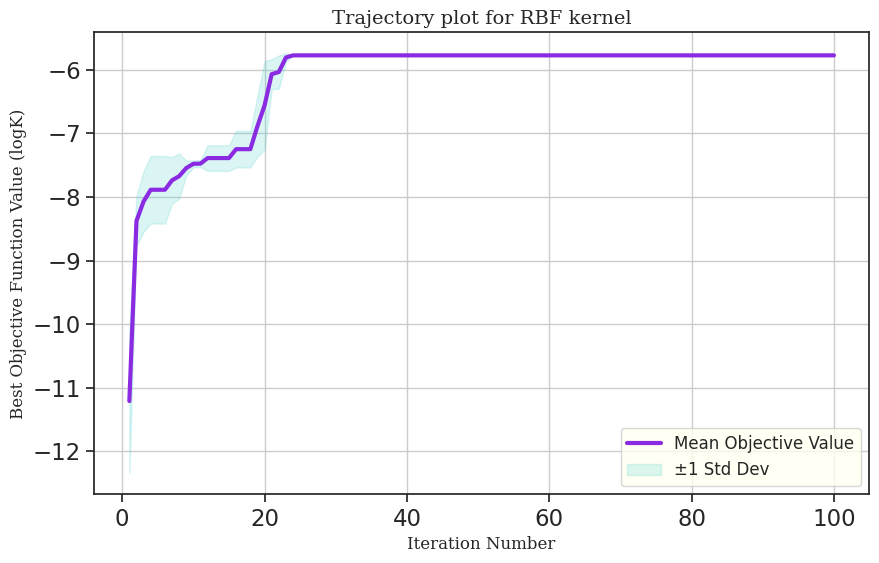

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def run_one_optimization(nb_iterations, init_sol_ids, verbose=False):
    #Run Bayesian Optimisation
    acquired_set = run_Bayesian_optimization(nb_iterations, init_sol_ids, verbose=verbose)
    #extract (y_train)
    y_train = build_y_train(acquired_set).numpy().ravel()
    best_so_far = [y_train[0]]
    for val in y_train[1:]:
        #maximum
        best_so_far.append(max(best_so_far[-1], val))

    return best_so_far

def run_multiple_optimizations(num_runs, nb_iterations, nb_SOLs, nb_solvent, initialization='random'):
    #decide initialisation
    all_runs_best = []

    for run_i in range(num_runs):
        if initialization == 'fixed':
            init_sol_ids = np.array(range(0, nb_solvent))
        else:
            #random
            init_sol_ids = np.random.randint(0, nb_SOLs, size=nb_solvent)

        best_so_far = run_one_optimization(nb_iterations, init_sol_ids, verbose=False)

        # Ensure we have nb_iterations values
        # If run_Bayesian_optimization stops early, pad with the last value
        if len(best_so_far) < nb_iterations:
            last_val = best_so_far[-1]
            best_so_far.extend([last_val]*(nb_iterations - len(best_so_far)))

        all_runs_best.append(best_so_far[:nb_iterations])

    #convert into numpy array
    all_runs_best = np.array(all_runs_best)
    return all_runs_best

def plot_mean_trajectory(all_runs_best):
    #mean and std
    mean_values = np.mean(all_runs_best, axis=0)
    std_values = np.std(all_runs_best, axis=0)

    nb_iterations = all_runs_best.shape[1]
    iterations = np.arange(1, nb_iterations + 1)


    plt.figure(figsize=(10, 6))
    plt.plot(iterations, mean_values, label='Mean Objective Value', color='blueviolet')
    plt.fill_between(iterations, mean_values - std_values, mean_values + std_values,
                     color='mediumturquoise', alpha=0.2, label='±1 Std Dev')
    plt.xlabel("Iteration Number", fontsize=12, fontfamily='serif')
    plt.ylabel("Best Objective Function Value (logK)", fontsize=12, fontfamily='serif')
    plt.title("Trajectory plot for RBF kernel", fontsize=14, fontfamily='serif')
    plt.grid(True)
    plt.legend(fontsize=12, facecolor='ivory', loc='lower right')
    plt.show()

#run here
num_runs = 5
nb_iterations = 100
all_runs_best = run_multiple_optimizations(num_runs, nb_iterations, nb_SOLs, nb_solvent, initialization='random')
start_time    = time.time()
plot_mean_trajectory(all_runs_best)


In [ ]:
print((y_train).shape)

torch.Size([20, 1])
